### Importing Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import numpy as np
import time



from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

from pyspark.sql.functions import col, count, when, mean,expr, avg, stddev
from pyspark.sql.functions import udf
from pyspark.ml.feature import VectorAssembler, StringIndexer, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

from pyspark.sql.types import DoubleType
from geopy.distance import geodesic

In [ ]:
import os
# Change KAGGLEHUB_CACHE to '/kaggle/working'
os.environ['KAGGLEHUB_CACHE'] = '/kaggle/working'

import kagglehub

# Download latest version
path = kagglehub.dataset_download("kartik2112/fraud-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fraud-detection


### Initialize Spark

In [ ]:
from pyspark import SparkConf

conf = SparkConf() \
    .setAppName("FraudDetection") \
    .setMaster("local[*]") \
    .set("spark.executor.memory", "8g") \
    .set("spark.driver.memory",   "4g") \
    .set("spark.sql.shuffle.partitions", "20")

spark = SparkSession.builder \
    .config(conf=conf) \
    .getOrCreate()

In [ ]:
train_path = "/kaggle/input/fraud-detection/fraudTrain.csv"

df = spark.read.csv(train_path, header=True, inferSchema=True)

In [ ]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [ ]:
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()
df = df.dropna()

+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|_c0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+
|  0|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|
+---+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+



### Feature Engineering



In [ ]:
windowSpec = Window.partitionBy('category')
df = df.withColumn(
    'amt_vs_category_avg',
    col('amt') / avg('amt').over(windowSpec)
)

In [ ]:
# Transforming the transaction date to datetime
df = df.withColumn("trans_date", F.to_timestamp("trans_date_trans_time")) \
       .withColumn("hour", F.hour("trans_date")) \
       .withColumn("day_of_week", F.dayofweek("trans_date")) \
       .withColumn("month", F.month("trans_date")) \
       .withColumn("age", F.year("trans_date") - F.year("dob"))

### Efficient Distance Calculation

In [ ]:
from pyspark.sql.functions import radians, sin, cos, sqrt, asin

start = time.time()
df = df.withColumn("lat_r",  radians("lat")) \
       .withColumn("lon_r",  radians("long")) \
       .withColumn("mlat_r", radians("merch_lat")) \
       .withColumn("mlon_r", radians("merch_long")) \
       .withColumn("dlat",    col("lat_r") - col("mlat_r")) \
       .withColumn("dlon",    col("lon_r") - col("mlon_r")) \
       .withColumn("a",      sin(col("dlat")/2)**2 \
                             + cos(col("lat_r"))*cos(col("mlat_r"))*sin(col("dlon")/2)**2) \
       .withColumn("distance", 2 * 6371 * asin(sqrt(col("a")))) \
       .drop("lat_r","lon_r","mlat_r","mlon_r","dlat","dlon","a")
print(f"Distance calc: {time.time() - start:.2f} s")

Distance calc: 1.78 s


In [ ]:
df = df.cache()
_  = df.count()   # trigger cache
print("✅ Finished preprocessing & cache: total rows =", df.count())

✅ Finished preprocessing & cache: total rows = 1296675


In [ ]:
df.show(5)

+---+---------------------+----------------+--------------------+-----------+------+---------+-------+------+--------------------+----------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+-------------------+-------------------+----+-----------+-----+---+------------------+
|_c0|trans_date_trans_time|          cc_num|            merchant|   category|   amt|    first|   last|gender|              street|            city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|amt_vs_category_avg|         trans_date|hour|day_of_week|month|age|          distance|
+---+---------------------+----------------+--------------------+-----------+------+---------+-------+------+--------------------+----------------+-----+-----+-------+------------------+--------+--------------------+----------+-

### Auto choose best stragegy

In [ ]:
def auto_balance_strategy(df, label_col="is_fraud", threshold_high=0.1, threshold_low=0.01):
    from pyspark.sql import functions as F

    majority_count = df.filter(F.col(label_col) == 0).count()
    minority_count = df.filter(F.col(label_col) == 1).count()

    fraud_ratio = minority_count / (majority_count + minority_count)
    print(f"Fraud Ratio: {fraud_ratio:.4f}")

    if fraud_ratio > threshold_high:
        print("📈 Data is fairly balanced. No need to balance.")
        strategy = "None"
    elif fraud_ratio > threshold_low:
        print("⚖️  Moderate imbalance detected. Using ClassWeight.")
        strategy = "ClassWeight"
    else:
        print("🚨 Severe imbalance detected. Using ClassWeight + Undersampling.")
        strategy = "ClassWeight+Undersampling"

    return strategy


strategy = auto_balance_strategy(df)

Fraud Ratio: 0.0058
🚨 Severe imbalance detected. Using ClassWeight + Undersampling.


### Process Imbalanced Data

In [ ]:
dist_counts = df.groupBy("is_fraud").count().collect()
maj  = next(r['count'] for r in dist_counts if r['is_fraud']==0)
minr = next(r['count'] for r in dist_counts if r['is_fraud']==1)
print(f"Non-Fraud: {maj} | Fraud: {minr}")

# 1.2) Undersample majority
undersample_multiplier = 10
fraction = min((undersample_multiplier * minr) / maj, 1.0)
print(f"Undersample fraction: {fraction:.4f}")

fraud_df    = df.filter(col("is_fraud")==1)
nonfraud_df = df.filter(col("is_fraud")==0) \
                 .sample(withReplacement=False, fraction=fraction, seed=42)
balanced_df = fraud_df.union(nonfraud_df)
print(f"Balanced size: {balanced_df.count()} rows")

# 1.3) Tính class weight
bal_ratio = nonfraud_df.count() / fraud_df.count()
balanced_df = balanced_df.withColumn(
    "classWeight",
    when(col("is_fraud")==1, F.lit(bal_ratio)).otherwise(F.lit(1.0))
)

Non-Fraud: 1289169 | Fraud: 7506
Undersample fraction: 0.0582
Balanced size: 82936 rows


### Split train/test dataset


In [ ]:
train_df, eval_df = balanced_df.randomSplit([0.8, 0.2], seed=42)
print(f"Train: {train_df.count()}, Eval: {eval_df.count()}")

Train: 66098, Eval: 16838


### Encoding Categories

In [ ]:
categorical_cols = ['merchant','category','gender','job']
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in categorical_cols
]

feature_cols = [
    'amt','city_pop','age','hour','month','day_of_week','distance','amt_vs_category_avg'
] + [f"{c}_idx" for c in categorical_cols] # Changed _Indexer to _idx

### Assemble Features

In [ ]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

### Define Evaluating Function

In [ ]:
def evaluate_model(predictions, model_name):
    # Tính toán metrics
    evaluator = BinaryClassificationEvaluator(labelCol="is_fraud")
    auc_roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    auc_pr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})

    # Chuẩn bị dữ liệu cho visualization
    pdf = predictions.select("is_fraud", "probability").toPandas()
    pdf['prob_fraud'] = pdf['probability'].apply(lambda x: x[1])
    y_true = pdf['is_fraud']
    y_prob = pdf['prob_fraud']

    # Visualization
    plt.figure(figsize=(15, 4))

    # ROC Curve
    plt.subplot(1, 3, 1)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")

    # PR Curve
    plt.subplot(1, 3, 2)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, color='blue', lw=2, label=f'AUC = {pr_auc:.2f}')
    plt.title(f'{model_name} PR Curve')
    plt.legend(loc="upper right")

    # Confusion Matrix
    plt.subplot(1, 3, 3)
    y_pred = np.where(y_prob >= 0.5, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')

    plt.tight_layout()
    plt.show()

    # Print metrics
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{model_name} Metrics:")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR: {auc_pr:.4f}")
    print(f"Precision: {tp/(tp+fp):.4f}")
    print(f"Recall: {tp/(tp+fn):.4f}")
    print(f"F1-Score: {2*(tp/(tp+fp))*(tp/(tp+fn))/(tp/(tp+fp)+tp/(tp+fn)):.4f}")

### Define Evaluator

In [ ]:
# Define Evaluator
evaluator_roc = BinaryClassificationEvaluator(
    labelCol="is_fraud",
    rawPredictionCol="probability",
    metricName="areaUnderROC"
)
evaluator_pr = BinaryClassificationEvaluator(
    labelCol="is_fraud",
    rawPredictionCol="probability",
    metricName="areaUnderPR"
)

### Random Forest

🔧 RF training time: 3086.86 s


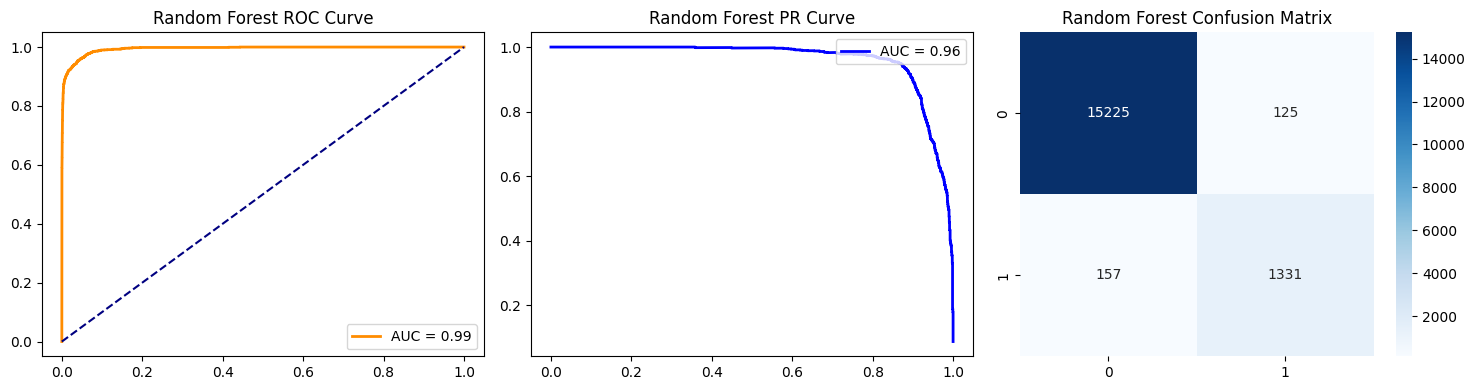


Random Forest Metrics:
AUC-ROC: 0.9939
AUC-PR: 0.9597
Precision: 0.9141
Recall: 0.8945
F1-Score: 0.9042


In [ ]:
# Model
rf = RandomForestClassifier(
    labelCol="is_fraud",
    featuresCol="features",
    weightCol="classWeight",
    seed=42,
    maxBins = 1000
)

# Param grid
rf_param_grid = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [50, 100])
                 .addGrid(rf.maxDepth, [5, 10])
                 .addGrid(rf.maxBins, [1000, 2000])
                 .build())

# Pipeline
rf_pipeline = Pipeline(stages=indexers + [assembler, rf])



# Cross-validator
rf_cv = CrossValidator(
    estimator=rf_pipeline,
    estimatorParamMaps=rf_param_grid,
    evaluator=evaluator_pr,
    numFolds=3,
    parallelism=4,
    seed=42
)

# Train
start = time.time()
rf_model = rf_cv.fit(train_df)
print(f"🔧 RF training time: {time.time() - start:.2f} s")

# Đánh giá
rf_predictions = rf_model.transform(eval_df)
evaluate_model(rf_predictions, "Random Forest")

### GBT Algorithm

🔧 GBT training time: 1256.34 s


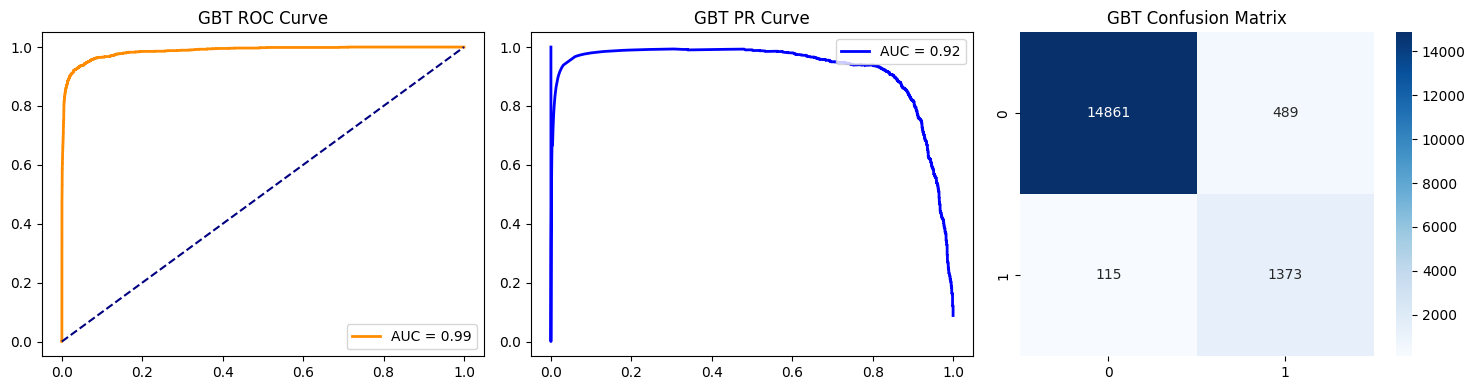


GBT Metrics:
AUC-ROC: 0.9866
AUC-PR: 0.9228
Precision: 0.7374
Recall: 0.9227
F1-Score: 0.8197


In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(
    labelCol="is_fraud",
    featuresCol="features",
    weightCol="classWeight",
    maxIter=50,
    maxDepth=5,
    seed=42,
    maxBins=1000 # Increased maxBins to accommodate the categorical feature with 694 values
)

gbt_param_grid = (ParamGridBuilder()
    .addGrid(gbt.maxIter,  [20,50])
    .addGrid(gbt.maxDepth, [3, 5])
    .build()
)

gbt_pipeline = Pipeline(stages=indexers + [assembler, gbt])
gbt_cv = TrainValidationSplit(
    estimator=gbt_pipeline,
    estimatorParamMaps=gbt_param_grid,
    evaluator=evaluator_pr,
    trainRatio=0.8,
    parallelism=2,
    seed=42
)

start = time.time()
gbt_model = gbt_cv.fit(train_df)
print(f"🔧 GBT training time: {time.time() - start:.2f} s")

# Đánh giá
gbt_predictions = gbt_model.transform(eval_df)
evaluate_model(gbt_predictions, "GBT")

In [ ]:
results = {
    "Random Forest": {
        "AUC-ROC": evaluator_pr.evaluate(rf_predictions, {evaluator_pr.metricName: "areaUnderROC"}),
        "AUC-PR": evaluator_pr.evaluate(rf_predictions, {evaluator_pr.metricName: "areaUnderPR"})
    },
    "GBT": {
        "AUC-ROC": evaluator_pr.evaluate(gbt_predictions, {evaluator_pr.metricName: "areaUnderROC"}),
        "AUC-PR": evaluator_pr.evaluate(gbt_predictions, {evaluator_pr.metricName: "areaUnderPR"})
    }
}

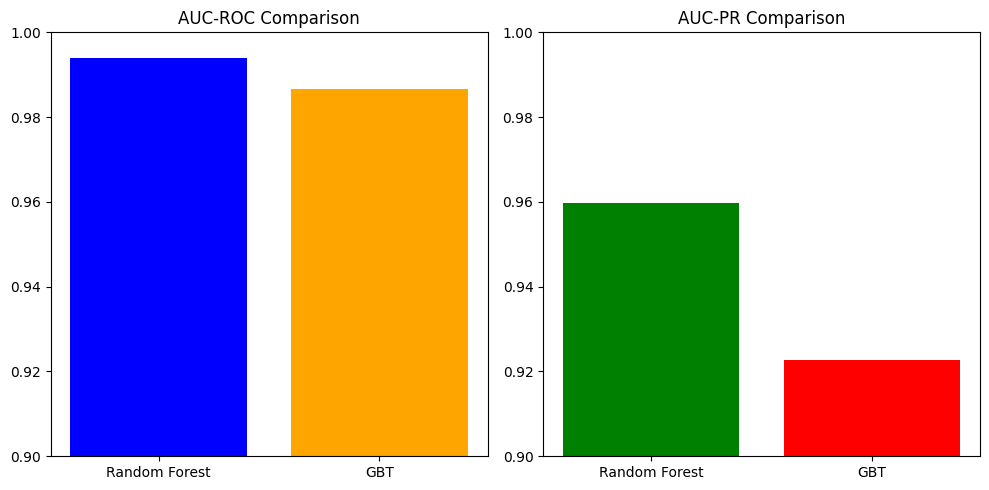

In [ ]:
# Vẽ biểu đồ so sánh
plt.figure(figsize=(10, 5))
models = list(results.keys())
roc_values = [results[m]["AUC-ROC"] for m in models]
pr_values = [results[m]["AUC-PR"] for m in models]

plt.subplot(1, 2, 1)
plt.bar(models, roc_values, color=['blue', 'orange'])
plt.title("AUC-ROC Comparison")
plt.ylim(0.9, 1.0)

plt.subplot(1, 2, 2)
plt.bar(models, pr_values, color=['green', 'red'])
plt.title("AUC-PR Comparison")
plt.ylim(0.9, 1.0)

plt.tight_layout()
plt.show()

In [ ]:
# Save the Random Forest model
rf_model.bestModel.save("/content/drive/MyDrive/rf_model")

# Save the GBT model
gbt_model.bestModel.save("/content/drive/MyDrive/gbt_model")